In [1]:
# Import all necessary libraries first
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from tqdm import tqdm

In [3]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

# Path to the training directory
train_dir = "/kaggle/input/chest-xray/chest_xray_jj_811/train"

# Create a dataset
dataset = ImageFolder(root=train_dir, transform=ToTensor())

# Print the automatically assigned class indices
print(dataset.class_to_idx)

# Define the directory paths
train_dir = "/kaggle/input/chest-xray/chest_xray_jj_811/train"
test_dir = "/kaggle/input/chest-xray/chest_xray_jj_811/test"
val_dir = "/kaggle/input/chest-xray/chest_xray_jj_811/val"

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=ToTensor())
test_dataset = ImageFolder(root=test_dir, transform=ToTensor())
val_dataset = ImageFolder(root=val_dir, transform=ToTensor())

# Print the number of samples in each split
print(f"Number of samples in TRAIN: {len(train_dataset)}")
print(f"Number of samples in TEST: {len(test_dataset)}")
print(f"Number of samples in VAL: {len(val_dataset)}")

{'BACTERIA': 0, 'NORMAL': 1, 'VIRUS': 2}
Number of samples in TRAIN: 4684
Number of samples in TEST: 585
Number of samples in VAL: 587


In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image settings
IMG_SIZE = 240
BATCH_SIZE = 32
NUM_WORKERS = 4


class GaussianBlur:
    """Custom transform for Gaussian Blur"""

    def __call__(self, img):
        np_img = np.array(img)
        blurred = cv2.GaussianBlur(np_img, (3, 3), 0)
        return transforms.functional.to_tensor(blurred)


# Define core preprocessing (applied to all splits)
core_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        GaussianBlur(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Additional augmentation for training only
train_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
        GaussianBlur(),  # Same Gaussian blur as in core transforms
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Validation/Test transforms are just the core transforms
val_transforms = core_transforms
test_transforms = core_transforms


# Load datasets
def load_data():
    train_dataset = datasets.ImageFolder(
        root="/kaggle/input/chest-xray/chest_xray_jj_811/train",
        transform=train_transforms,
    )

    val_dataset = datasets.ImageFolder(
        root="/kaggle/input/chest-xray/chest_xray_jj_811/val",
        transform=val_transforms,
    )

    test_dataset = datasets.ImageFolder(
        root="/kaggle/input/chest-xray/chest_xray_jj_811/test",
        transform=val_transforms,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
    )

    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = load_data()

In [5]:
class ChestXrayModel(nn.Module):
    def __init__(self):
        super(ChestXrayModel, self).__init__()
        # Load pretrained EfficientNetB1
        self.efficientnet = models.efficientnet_b1(pretrained=True)

        # Freeze base model parameters
        for param in self.efficientnet.parameters():
            param.requires_grad = False

        # Modify classifier
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(num_ftrs, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, 3),
        )

    def forward(self, x):
        return self.efficientnet(x)


def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), correct / total


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(loader), correct / total


# Initialize history dictionary for both phases
history = {
    "phase1": {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    },
    "phase2": {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    },
}
# Load data
train_loader, val_loader, test_loader = load_data()

# Initialize model
model = ChestXrayModel().to(device)
criterion = nn.CrossEntropyLoss()

# First training phase with frozen base
print("Phase 1: Training with frozen base model...")
optimizer = optim.Adam(model.efficientnet.classifier.parameters(), lr=0.001)

for epoch in range(20):
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Save metrics for phase 1
    history["phase1"]["train_loss"].append(train_loss)
    history["phase1"]["val_loss"].append(val_loss)
    history["phase1"]["train_acc"].append(train_acc)
    history["phase1"]["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/20:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n")

# Unfreeze last few layers for fine-tuning
print("\nPhase 2: Fine-tuning model...")
for param in model.efficientnet.features[-3:].parameters():
    param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

for epoch in range(20):
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Save metrics for phase 2
    history["phase2"]["train_loss"].append(train_loss)
    history["phase2"]["val_loss"].append(val_loss)
    history["phase2"]["train_acc"].append(train_acc)
    history["phase2"]["val_acc"].append(val_acc)

    print(f"Fine-tuning Epoch {epoch+1}/12:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n")

# Save model and complete history
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "history": history,
    },
    "chest_xray_model_complete.pth",
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 110MB/s] 


Phase 1: Training with frozen base model...


Validation: 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]


Epoch 1/20:
Train Loss: 0.6954, Train Acc: 0.7109
Val Loss: 0.7462, Val Acc: 0.7155



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.76it/s]


Epoch 2/20:
Train Loss: 0.6053, Train Acc: 0.7498
Val Loss: 0.7434, Val Acc: 0.6985



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.62it/s]


Epoch 3/20:
Train Loss: 0.5931, Train Acc: 0.7637
Val Loss: 0.6045, Val Acc: 0.7428



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.71it/s]


Epoch 4/20:
Train Loss: 0.5876, Train Acc: 0.7600
Val Loss: 0.7031, Val Acc: 0.7394



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.26it/s]


Epoch 5/20:
Train Loss: 0.5677, Train Acc: 0.7699
Val Loss: 0.6359, Val Acc: 0.7700



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.73it/s]


Epoch 6/20:
Train Loss: 0.5690, Train Acc: 0.7684
Val Loss: 0.6445, Val Acc: 0.7581



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


Epoch 7/20:
Train Loss: 0.5579, Train Acc: 0.7792
Val Loss: 0.6144, Val Acc: 0.7547



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.51it/s]


Epoch 8/20:
Train Loss: 0.5467, Train Acc: 0.7701
Val Loss: 0.6202, Val Acc: 0.7649



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.74it/s]


Epoch 9/20:
Train Loss: 0.5646, Train Acc: 0.7679
Val Loss: 0.5997, Val Acc: 0.7700



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


Epoch 10/20:
Train Loss: 0.5618, Train Acc: 0.7711
Val Loss: 0.5890, Val Acc: 0.7785



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.73it/s]


Epoch 11/20:
Train Loss: 0.5588, Train Acc: 0.7686
Val Loss: 0.6189, Val Acc: 0.7564



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.61it/s]


Epoch 12/20:
Train Loss: 0.5535, Train Acc: 0.7688
Val Loss: 0.5976, Val Acc: 0.7581



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.61it/s]


Epoch 13/20:
Train Loss: 0.5451, Train Acc: 0.7731
Val Loss: 0.6370, Val Acc: 0.7530



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.71it/s]


Epoch 14/20:
Train Loss: 0.5383, Train Acc: 0.7735
Val Loss: 0.6243, Val Acc: 0.7683



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.60it/s]


Epoch 15/20:
Train Loss: 0.5399, Train Acc: 0.7713
Val Loss: 0.6730, Val Acc: 0.7479



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.29it/s]


Epoch 16/20:
Train Loss: 0.5463, Train Acc: 0.7735
Val Loss: 0.5993, Val Acc: 0.7428



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


Epoch 17/20:
Train Loss: 0.5526, Train Acc: 0.7728
Val Loss: 0.6698, Val Acc: 0.7428



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.72it/s]


Epoch 18/20:
Train Loss: 0.5384, Train Acc: 0.7839
Val Loss: 0.6128, Val Acc: 0.7496



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.56it/s]


Epoch 19/20:
Train Loss: 0.5301, Train Acc: 0.7805
Val Loss: 0.6186, Val Acc: 0.7479



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.71it/s]


Epoch 20/20:
Train Loss: 0.5361, Train Acc: 0.7716
Val Loss: 0.6211, Val Acc: 0.7734


Phase 2: Fine-tuning model...


Validation: 100%|██████████| 19/19 [00:05<00:00,  3.60it/s]


Fine-tuning Epoch 1/12:
Train Loss: 0.5202, Train Acc: 0.7852
Val Loss: 0.5226, Val Acc: 0.7836



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.69it/s]


Fine-tuning Epoch 2/12:
Train Loss: 0.4669, Train Acc: 0.8053
Val Loss: 0.5103, Val Acc: 0.7734



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.66it/s]


Fine-tuning Epoch 3/12:
Train Loss: 0.4556, Train Acc: 0.8047
Val Loss: 0.5271, Val Acc: 0.7871



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.34it/s]


Fine-tuning Epoch 4/12:
Train Loss: 0.4396, Train Acc: 0.8192
Val Loss: 0.5071, Val Acc: 0.7905



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.68it/s]


Fine-tuning Epoch 5/12:
Train Loss: 0.4217, Train Acc: 0.8271
Val Loss: 0.4998, Val Acc: 0.8058



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.71it/s]


Fine-tuning Epoch 6/12:
Train Loss: 0.4071, Train Acc: 0.8269
Val Loss: 0.4574, Val Acc: 0.8092



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.69it/s]


Fine-tuning Epoch 7/12:
Train Loss: 0.4047, Train Acc: 0.8303
Val Loss: 0.5080, Val Acc: 0.8024



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.68it/s]


Fine-tuning Epoch 8/12:
Train Loss: 0.3966, Train Acc: 0.8328
Val Loss: 0.4701, Val Acc: 0.8160



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.35it/s]


Fine-tuning Epoch 9/12:
Train Loss: 0.3950, Train Acc: 0.8290
Val Loss: 0.4470, Val Acc: 0.8194



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.65it/s]


Fine-tuning Epoch 10/12:
Train Loss: 0.3684, Train Acc: 0.8456
Val Loss: 0.4403, Val Acc: 0.8313



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.62it/s]


Fine-tuning Epoch 11/12:
Train Loss: 0.3565, Train Acc: 0.8531
Val Loss: 0.4553, Val Acc: 0.8194



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.72it/s]


Fine-tuning Epoch 12/12:
Train Loss: 0.3498, Train Acc: 0.8523
Val Loss: 0.4009, Val Acc: 0.8433



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.69it/s]


Fine-tuning Epoch 13/12:
Train Loss: 0.3510, Train Acc: 0.8486
Val Loss: 0.4414, Val Acc: 0.8058



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.36it/s]


Fine-tuning Epoch 14/12:
Train Loss: 0.3456, Train Acc: 0.8538
Val Loss: 0.4375, Val Acc: 0.8109



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.69it/s]


Fine-tuning Epoch 15/12:
Train Loss: 0.3356, Train Acc: 0.8621
Val Loss: 0.3702, Val Acc: 0.8382



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.75it/s]


Fine-tuning Epoch 16/12:
Train Loss: 0.3147, Train Acc: 0.8668
Val Loss: 0.3879, Val Acc: 0.8296



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.70it/s]


Fine-tuning Epoch 17/12:
Train Loss: 0.3040, Train Acc: 0.8691
Val Loss: 0.4000, Val Acc: 0.8262



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.69it/s]


Fine-tuning Epoch 18/12:
Train Loss: 0.3047, Train Acc: 0.8696
Val Loss: 0.4079, Val Acc: 0.8348



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.39it/s]


Fine-tuning Epoch 19/12:
Train Loss: 0.3018, Train Acc: 0.8757
Val Loss: 0.3981, Val Acc: 0.8348



Validation: 100%|██████████| 19/19 [00:05<00:00,  3.73it/s]


Fine-tuning Epoch 20/12:
Train Loss: 0.2915, Train Acc: 0.8745
Val Loss: 0.3920, Val Acc: 0.8399



<ipython-input-7-806f2b9d2348>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/usr/local/lib/python3.10/dist-packages/torchvision/mode

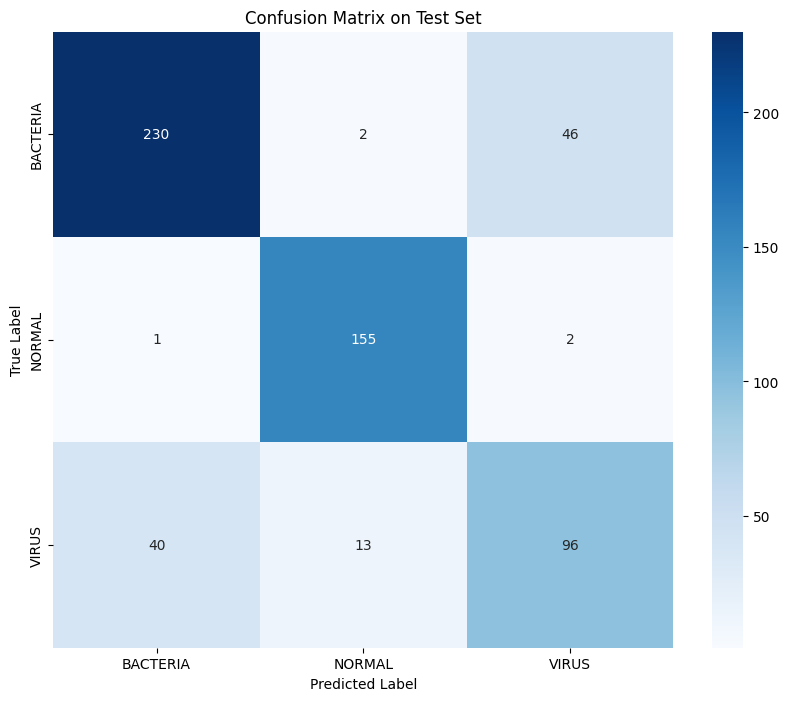


Test Set Metrics:
Macro F1 Score: 0.8128

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       278
           1       0.91      0.98      0.95       158
           2       0.67      0.64      0.66       149

    accuracy                           0.82       585
   macro avg       0.81      0.82      0.81       585
weighted avg       0.82      0.82      0.82       585



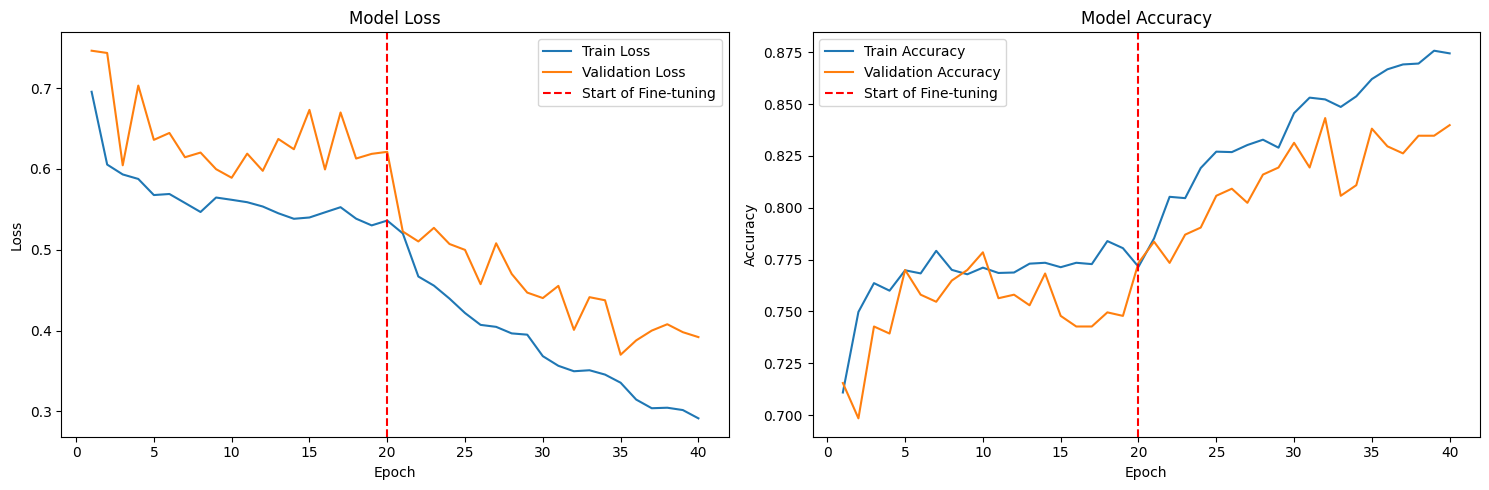

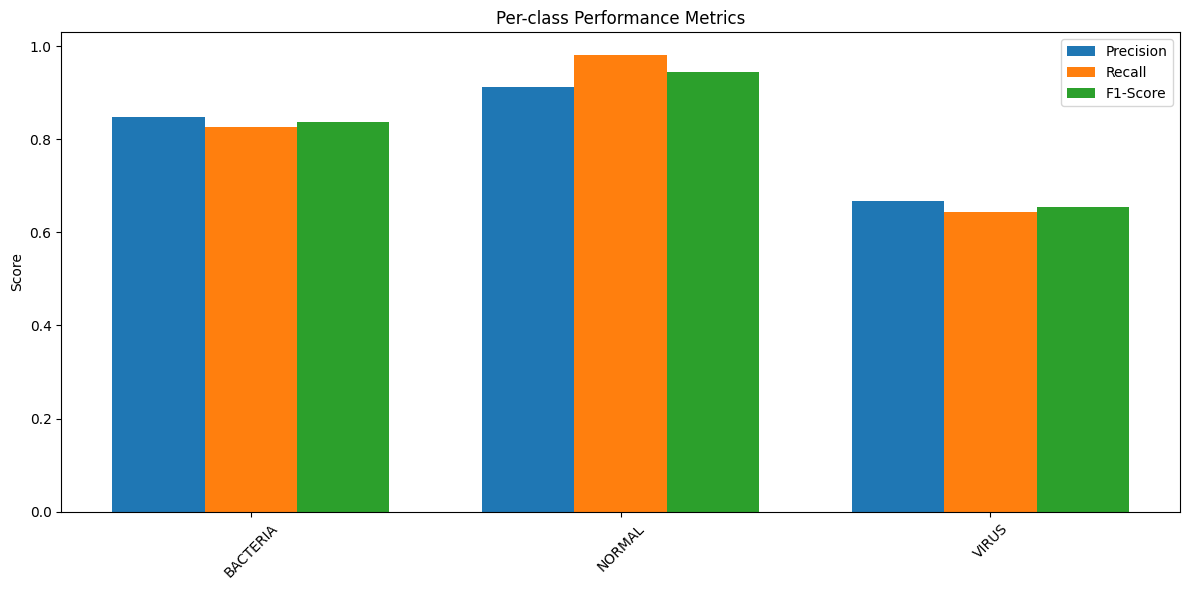

In [7]:
def load_test_data(
    test_dir="/kaggle/input/chest-xray/chest_xray_jj_811/test", batch_size=32
):
    """Load the test dataset with proper transforms"""
    # Define core preprocessing (same as training, but without augmentation)
    test_transforms = transforms.Compose(
        [
            transforms.Resize((240, 240)),
            GaussianBlur(),  # Same Gaussian blur as in training
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    # Load test dataset
    test_dataset = datasets.ImageFolder(
        root=test_dir,
        transform=test_transforms,
    )

    # Create test dataloader
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,  # Don't shuffle test data
        num_workers=4,
    )

    return test_loader


def evaluate_model(model_path, test_loader, device):
    """Complete model evaluation on test set"""
    # Load the trained model
    checkpoint = torch.load(model_path)
    model = ChestXrayModel()  # Make sure this matches your training architecture
    model.load_state_dict(checkpoint["model_state_dict"])
    model = model.to(device)
    model.eval()  # Set to evaluation mode

    # Get predictions on test set
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # No gradient computation needed for testing
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)  # Remove squeeze since we have 3 outputs
            _, predictions = torch.max(outputs, 1)  # Get class with highest probability

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Calculate metrics
    # Use 'macro' average for multi-class
    f1 = f1_score(all_labels, all_predictions, average="macro")
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    class_report = classification_report(all_labels, all_predictions)

    # Get class names from test loader
    class_names = test_loader.dataset.classes

    # Plot confusion matrix with class labels
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title("Confusion Matrix on Test Set")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # Print metrics
    print("\nTest Set Metrics:")
    print(f"Macro F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(class_report)

    # Plot training history if available
    if "history" in checkpoint:
        plot_complete_training_history(checkpoint["history"])

    return {
        "f1_score": f1,
        "confusion_matrix": conf_matrix,
        "predictions": all_predictions,
        "true_labels": all_labels,
        "class_names": class_names,
    }


# Add this function to plot per-class metrics
def plot_per_class_metrics(results):
    """Plot per-class precision, recall, and F1 scores"""
    class_names = results["class_names"]
    report = classification_report(
        results["true_labels"], results["predictions"], output_dict=True
    )

    # Extract per-class metrics
    metrics = []
    for class_name in class_names:
        metrics.append(
            {
                "Class": class_name,
                "Precision": report[str(class_names.index(class_name))]["precision"],
                "Recall": report[str(class_names.index(class_name))]["recall"],
                "F1-Score": report[str(class_names.index(class_name))]["f1-score"],
            }
        )

    # Create DataFrame for plotting
    df_metrics = pd.DataFrame(metrics)

    # Plot
    plt.figure(figsize=(12, 6))
    x = np.arange(len(class_names))
    width = 0.25

    plt.bar(x - width, df_metrics["Precision"], width, label="Precision")
    plt.bar(x, df_metrics["Recall"], width, label="Recall")
    plt.bar(x + width, df_metrics["F1-Score"], width, label="F1-Score")

    plt.ylabel("Score")
    plt.title("Per-class Performance Metrics")
    plt.xticks(x, class_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_complete_training_history(history):
    """Plot training history metrics for both phases"""
    plt.figure(figsize=(15, 5))

    # Combine histories from both phases
    train_loss = history["phase1"]["train_loss"] + history["phase2"]["train_loss"]
    val_loss = history["phase1"]["val_loss"] + history["phase2"]["val_loss"]
    train_acc = history["phase1"]["train_acc"] + history["phase2"]["train_acc"]
    val_acc = history["phase1"]["val_acc"] + history["phase2"]["val_acc"]

    # Create epoch numbers for x-axis
    epochs = range(1, len(train_loss) + 1)
    phase1_end = len(history["phase1"]["train_loss"])

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.axvline(x=phase1_end, color="r", linestyle="--", label="Start of Fine-tuning")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.axvline(x=phase1_end, color="r", linestyle="--", label="Start of Fine-tuning")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Usage:
test_loader = load_test_data()
results = evaluate_model("chest_xray_model_complete.pth", test_loader, device)
plot_per_class_metrics(results)